# Calculate the boundary depth

- Until xarrays patch version is released, I need to install from upstream master to fix this weird time slicing problem (cant find the issue right now...)
- The algo still has issues: I need to build in a concrete check that the upper/lower boundary is not at the same depth as the minimum otherwise the upper lower boundary just track the minimum I think.

In [1]:
import dask
from multiprocessing.pool import ThreadPool
dask.config.set(pool=ThreadPool(16))

In [17]:
import intake
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

from dask.diagnostics import ProgressBar
from distributed import LocalCluster, Client
from fastprogress import progress_bar
from xarrayutils.utils import linear_trend
from xarrayutils.plotting import map_util_plot
from xarrayutils.file_handling import write, maybe_create_folder


from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import concat_experiments


from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import append_write_zarr, zarr_exists
from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.units import convert_mol_m3_mymol_kg

In [3]:
# # set up dask
# from dask.distributed import LocalCluster, Client
# mem_total = 200
# workers = 8
# threads = 5 # 4*6 seemed to work quite well, but I would like this to perform a bit better
# cluster = LocalCluster(
#     memory_limit=f"{int(mem_total/workers)}GiB",
#     dashboard_address=9999,
#     threads_per_worker=threads,
#     n_workers = workers,
#                       )
# client = Client(cluster)
# client

## Load the historical and ssp data for oxygen

In [4]:
o2_models()

['ACCESS-ESM1-5',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-ESM2',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'EC-Earth3-CC',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'UKESM1-0-LL']

In [5]:
col = cmip6_collection(zarr=False)

kwargs = {
    "preprocess": combined_preprocessing,
    "cdf_kwargs": {"use_cftime": True, "chunks": {"time": 1}, "engine": "h5netcdf"},
    "zarr_kwargs": {"use_cftime": True, "consolidated": True},
    "aggregate": False,
}
cat = col.search(
    #     source_id=o2_models(),
    source_id=[
        "ACCESS-ESM1-5",  #some but maybe not all members processed.
        "CNRM-ESM2-1",  #some but maybe not all members processed.
        "CanESM5",  #some but maybe not all members processed.
        "IPSL-CM6A-LR", #some but maybe not all members processed.
#         
        #------ already processed
#         "CanESM5-CanOE",
#         "MPI-ESM1-2-HR",
#         "MPI-ESM1-2-LR",
#         "MRI-ESM2-0",
#         "NorESM2-LM",
#         "NorESM2-MM",
#         "UKESM1-0-LL",
        # already processed with all members
#         "MIROC-ES2L",
#         "GFDL-CM4",
#         "GFDL-ESM4",       
    ],
    variable_id=["o2"],
    experiment_id=["historical", "ssp585"],
)
ddict = cat.to_dataset_dict(**kwargs)

Dataframe size before picking latest version: 2280
Getting latest version...

Dataframe size after picking latest version: 2258

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


## Detrend

In [6]:
# Load all trend files
flist = list(pathlib.Path('../../data/external/cmip6_control_drifts/').absolute().glob('*.nc'))
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

# detrend
ddict_detrended = match_and_remove_trend(
    ddict,
    trend_dict,
    check_mask=False # should be deactivated once the trends are completed (i have a few in there now that dont have a nanmask applied)
)

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r18i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CCCma.CanESM5.ssp585.r7i1p2f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r31i1p1f1.Oyr.gn.v20210

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.IPSL.IPSL-CM6A-LR.historical.r9i1p1f1.Oyr.gn.none.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.IPSL.IPSL-CM6A-LR.historical.r23i1p1f1.Oyr.gn.none.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r4i1p1f1.Oyr.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r25i1p1f1.Omon.gn.v20200922.

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.Oyr.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Oyr

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r27i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Om

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r21i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r19i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r22i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.gn.v20200

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CCCma.CanESM5.ssp585.r3i1p1f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r24i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r19i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.Omon.gn.v2020

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r10i1p2f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r25i1p1f1.Omon.gn.v201904

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Oyr.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r15i1p1f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r28i1p1f1.Omon.gn.v2020092

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r18i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r17i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r19i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r19i1p1f1.Omon.gn.v20190429.o2

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r25i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r23i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.Omon.gn.

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r21i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r13i1p1f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r11i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r13i1p1f1.Omon.gn.v

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r29i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r19i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r9i1p1f1.Oyr.gn.v20200529.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r23i1p1f1.Omon.gn.v2

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r4i1p1f1.Oyr.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r8i1p1f1.Oyr.gn.v20200529.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r25i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r4i1p1f1.O

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r32i1p1f1.Oyr.gn.v20210525.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r4i1p1f1.O

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r7i1p1f1.Omon.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1.Oyr.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r24i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r21i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r24i1p1f1.Omon.gn.

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r18i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r11i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r29i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r25i1p1f1.Omon.gn.v20190

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r1i1p1f1.Oyr.gn.v20191115.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.Oyr.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Oyr.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r24i1p1f1.Omon.g

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r5i1p1f1.Oyr.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r7i1p1f1.Omon.gn.v20210318.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r12i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r6i1p2f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r20i1p1f1.Oyr.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r30i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r32i1p1f1.Oyr.gn.v20210525.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Omo

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r23i1p1f1.Omon.gn.v20200922.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r21i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r17i1p1f1.Omon.gn.v20190

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r12i1p1f1.Omon.gn.v20200803.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.CCCma.CanESM5.ssp585.r4i1p2f1.Oyr.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r12i1p1f1.Omon.gn

In [7]:
ddict_full_run = concat_experiments(ddict_detrended)

In [8]:
# filter out the ones that dont have the full time range
ddict_full_run = {k:ds for k,ds in ddict_full_run.items() if len(ds.time) > 3000}

In [9]:
# # Check only the first member
# from cmip6_omz.upstream_stash import pick_first_member
# ddict_full_run = pick_first_member(ddict_full_run)

In [10]:
for name, ds in ddict_full_run.items():
    print(f"{name} {len(ds.time)}")

CanESM5.gn.Omon.r3i1p1f1.o2 3012
CNRM-ESM2-1.gn.Omon.r5i1p1f2.o2 3012
CanESM5.gn.Omon.r1i1p2f1.o2 3012
CanESM5.gn.Omon.r8i1p2f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r8i1p1f1.o2 5412
CanESM5.gn.Omon.r4i1p2f1.o2 3012
CanESM5.gn.Omon.r7i1p2f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r5i1p1f1.o2 3612
ACCESS-ESM1-5.gn.Omon.r2i1p1f1.o2 5052
CanESM5.gn.Omon.r7i1p1f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r10i1p1f1.o2 4092
CanESM5.gn.Omon.r4i1p1f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r4i1p1f1.o2 3612
CanESM5.gn.Omon.r9i1p2f1.o2 3012
CanESM5.gn.Omon.r8i1p1f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r9i1p1f1.o2 5412
CanESM5.gn.Omon.r5i1p1f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r6i1p1f1.o2 4932
CanESM5.gn.Omon.r6i1p2f1.o2 3012
CanESM5.gn.Omon.r9i1p1f1.o2 3012
CanESM5.gn.Omon.r5i1p2f1.o2 3012
ACCESS-ESM1-5.gn.Omon.r3i1p1f1.o2 3132
CanESM5.gn.Omon.r10i1p2f1.o2 3012
CanESM5.gn.Omon.r1i1p1f1.o2 5412
ACCESS-ESM1-5.gn.Omon.r1i1p1f1.o2 5052
CanESM5.gn.Omon.r2i1p1f1.o2 3012
CanESM5.gn.Omon.r2i1p2f1.o2 3012
CanESM5.gn.Omon.r10i1p1f1.o2 3012
CanESM5.gn.Omon

## Output boundary data

In [11]:
ofolder = maybe_create_folder('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0')

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder /projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0 does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


In [12]:
def wrapper_boundary(ds):
    attrs = ds.attrs #workaround until https://github.com/jbusecke/cmip6_omz/issues/30 is implemented.

#     th = 80/1e6*1025
#     th_raw = np.hstack([np.arange(0, 120, 10)])
#     th_raw = np.hstack([np.arange(0, 200, 20)]) # new for v1.0
    th_raw = np.array([10, 20, 30, 100, 120, 140])
    th_converted = th_raw / convert_mol_m3_mymol_kg(xr.DataArray([1.0])).data
    
    th = xr.DataArray(th_converted, dims="o2_threshold", coords={"o2_threshold": th_converted})
    
#     th = th.chunk({'o2_threshold':1})
    
    oc = omz_boundaries(ds.lev, ds.o2, th)
    oc = oc.assign_coords(o2_threshold=th_raw)
    oc.o2_threshold.attrs['units'] = '$\mu$mol/kg'
    
    oc.attrs = {k:v for k,v in attrs.items() if k not in ['intake_esm_varname']}
    
    #drop duplicate values
    for va in ['o2_min_lev', 'o2_min_value']:
        oc[va] = oc[va].isel(o2_threshold=0).squeeze()
    
    return oc

In [29]:
boundary_dict = {}
for name, ds in ddict_full_run.items():

    ds_id = cmip6_dataset_id(ds)
    
    oc = wrapper_boundary(ds)
    
    filename = ofolder.joinpath(f"{ds_id}_omz_boundary.zarr")
    print(filename)
    # average yearly to save some space
    oc = oc.coarsen(time=12).mean()
    if zarr_exists(filename):
        print('already processed')
    else:
#         with ProgressBar():
        dim_split = 5 if 'GFDL' in name else 10
        append_write_zarr(oc, filename, dim_split)
    print('-----------------')

/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CCCma.CanESM5.none.r3i1p1f1.Omon.gn.v20190429.o2_omz_boundary.zarr
already processed
-----------------
/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CNRM-CERFACS.CNRM-ESM2-1.none.r5i1p1f2.Omon.gn.none.o2_omz_boundary.zarr
already processed
-----------------
/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CCCma.CanESM5.none.r1i1p2f1.Omon.gn.v20190429.o2_omz_boundary.zarr
already processed
-----------------
/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CCCma.CanESM5.none.r8i1p2f1.Omon.gn.v20190429.o2_omz_boundary.zarr
already processed
-----------------
/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CSIRO.ACCESS-ESM1-5.none.r8i1p1f1.Omon.gn.none.o2_omz_boundary.zarr
already processed
-----------------
/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/none.CCCma.CanESM5.none.r4i1p2f1.Omon.gn.v20190429.o2_omz_boundary.zarr
alr

## Do the obs

- adjust the naming (for now I have copied this dataset to the 'more_members' folder

In [14]:
# from cmip6_omz.datasets import reconstruct_areacello
# import xarray as xr
# import numpy as np

from cmip6_omz.datasets import load_bianchi

ds_obs = load_bianchi()
ds_obs

<xarray.Dataset>
Dimensions:     (x: 360, y: 180, lev: 33, bnds: 2)
Coordinates:
  * x           (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    lev_bounds  (lev, bnds) float64 ...
    lon         (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat         (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds   (bnds) float64 165.7 196.0
    o2          (lev, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan


/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/cmip6_omz/datasets.py:35: UserWarning: No bounds found for lon and lat. Reconstructing with a very simplified method. Check results carefully.
  warnings.warn(


<xarray.Dataset>
Dimensions:     (lev: 33, y: 180, x: 360, bnds: 2)
Coordinates:
  * x           (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y           (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    lev_bounds  (lev, bnds) float64 ...
    lon         (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat         (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    areacello   (x, y) float64 -1.925e+10 3.225e+08 ... 3.225e+08 1.075e+08
Dimensions without coordinates: bnds
Data variables:
    o2          (lev, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [21]:
oc_obs = wrapper_boundary(ds_obs)
oc_obs

<xarray.Dataset>
Dimensions:         (x: 360, y: 180, o2_threshold: 6)
Coordinates:
  * x               (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * y               (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lon             (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat             (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    areacello       (x, y) float64 -1.925e+10 3.225e+08 ... 3.225e+08 1.075e+08
  * o2_threshold    (o2_threshold) int64 10 20 30 100 120 140
Data variables:
    o2_min_lev      (y, x) float64 0.0 0.0 0.0 0.0 ... 2.5e+03 2.5e+03 2.5e+03
    o2_min_value    (y, x) float64 1e+32 1e+32 1e+32 ... 0.2958 0.2956 0.2955
    upper_boundary  (y, x, o2_threshold) float64 nan nan nan ... 2.5e+03 2.5e+03
    lower_boundary  (y, x, o2_threshold) float64 0.0 0.0 0.0 ... 2.5e+03 2.5e+03

In [24]:
oc_obs.to_zarr(ofolder.joinpath('obs.zarr'))

In [25]:
oc_obs_masked = oc_obs.copy()
oc_obs_masked['o2_min_value'] = convert_mol_m3_mymol_kg(oc_obs_masked['o2_min_value'])
oc_obs_masked = oc_obs_masked.where(oc_obs_masked.o2_min_value <=150)

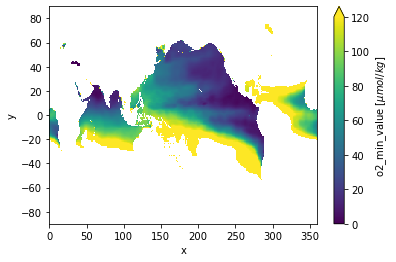

In [26]:
oc_obs_masked.o2_min_value.plot(vmax=120)

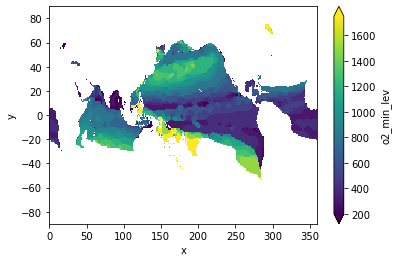

In [27]:
oc_obs_masked.o2_min_lev.plot(robust=True)